In [23]:
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn import model_selection
from sklearn import preprocessing
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn_pandas import gen_features
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from time import time
from scipy.stats import randint as sp_randint

#warmstart only useful when you want to add more estimators!
#regr = RandomForestRegressor(n_jobs=-1, random_state=0,n_estimators=100,max_features = 5, warm_start = True)#,oob_score=True, verbose = 1) # verbose only prints time and parallel jobs..oob score doesnt help the fit accuracy
regr = RandomForestRegressor(n_jobs=-1, random_state=0,n_estimators=500, warm_start = True, oob_score=True)
lr = LinearRegression()

scores = pd.read_csv('soretdScores.csv', lineterminator='\n')

data = pd.read_csv('motionData.csv', lineterminator='\n')
data.rename(columns={"FFPType\r": "FFPType"},inplace=True)

FEATURES = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration"]
FEATURESALL = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration", "FFPType"]

EMOSCORES = ["happier_mu", "sadder_mu", "angrier_mu"]
EMOCONFIDENCE_INV = ["happier_sigma", "sadder_sigma", "angrier_sigma"]
min_confidence = 25/3 # true skill base confidence: http://trueskill.org/
EMOWTS = ["happier_wt", "sadder_wt", "angrier_wt"]

emotionid = 0;

In [9]:
mapper = DataFrameMapper([
...     (["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration"], preprocessing.StandardScaler()),
...     (['FFPType'], preprocessing.OneHotEncoder())], input_df = True, sparse = True)

In [10]:
transformedData = mapper.fit_transform(data.copy())

In [11]:
WTS= {'happier_wt':(1.5-(scores[EMOCONFIDENCE_INV[0]]/min_confidence)).values,
                   'sadder_wt':(1.5-(scores[EMOCONFIDENCE_INV[1]]/min_confidence)).values,
                'angrier_wt':(1.5-(scores[EMOCONFIDENCE_INV[2]]/min_confidence)).values}
WTS_df = pd.DataFrame(WTS,scores.index)
scores_WTS = pd.concat([scores, WTS_df], axis = 1)

In [12]:
 X_train, X_test, y_train, y_test = model_selection.train_test_split(transformedData, scores_WTS, test_size=0.2, random_state=42)

In [12]:
# specify parameters and distributions to sample from
param_dist = {"max_depth": [3,5,10, 15, 20, 25, 30, None],
              "max_features": sp_randint(3, 15),
              #"min_samples_split": sp_randint(3, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "criterion": ["mse", "mae"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(regr, param_distributions=param_dist,
                                   n_iter=n_iter_search, n_jobs=-1, cv =10, random_state = 0)

start = time()
random_search.fit(X_train, y_train[EMOSCORES[emotionid]], sample_weight=y_train[EMOWTS[emotionid]])
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
print(random_search.cv_results_)

RandomizedSearchCV took 92.43 seconds for 20 candidates parameter settings.
{'mean_fit_time': array([ 1.2887306 ,  2.8256161 ,  4.13219137,  1.64577763,  1.96813488,
        1.32943623,  3.94459252,  5.13455756,  3.30017846,  2.00162404,
        2.80616405,  1.40373397,  2.68303645,  5.61754229,  5.14849472,
        1.76318982,  1.05410368,  3.46441493,  3.07327461,  3.43002379]), 'std_fit_time': array([ 0.83456726,  0.24457225,  0.4861944 ,  0.30301317,  0.24445677,
        0.21199934,  0.63415857,  0.62119074,  1.17497554,  0.31037939,
        0.31749867,  0.30850034,  0.3086703 ,  0.63498659,  0.6763149 ,
        0.77058617,  0.13796039,  0.57504769,  0.42774775,  0.21491321]), 'mean_score_time': array([ 0.11369691,  0.23693011,  0.42974303,  0.11149657,  0.14558725,
        0.31764514,  0.66306348,  0.20735171,  0.11500559,  0.14679048,
        0.16995211,  0.17316043,  0.61744239,  1.30075994,  0.15090148,
        0.1056812 ,  0.16604147,  0.55918739,  0.39344652,  0.3397471 ]), '

In [13]:
random_search.best_estimator_ 

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=15,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=8,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=True, random_state=0,
           verbose=0, warm_start=True)

In [14]:
random_search.best_score_

0.36050727996889181

In [15]:
ytest_pred_Randcv=random_search.best_estimator_.predict(X_test)
ytrain_pred_Randcv=random_search.best_estimator_.predict(X_train)

In [16]:
random_search.best_params_

{'criterion': 'mae', 'max_depth': 15, 'max_features': 6, 'min_samples_leaf': 8}

In [17]:
print("Mean squared error wtd random cv (test): %.2f"
      % mean_squared_error( y_test[EMOSCORES[emotionid]],ytest_pred_Randcv,sample_weight=y_test[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score wtd random cv (test): %.4f' % r2_score( y_test[EMOSCORES[emotionid]],ytest_pred_Randcv,sample_weight=y_test[EMOWTS[emotionid]]))

Mean squared error wtd random cv (test): 18.79
Variance score wtd random cv (test): 0.4670


In [18]:
print("Mean squared error wtd (train): %.2f"
      % mean_squared_error( y_train[EMOSCORES[emotionid]],ytrain_pred_Randcv,sample_weight=y_train[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score wtd (train): %.2f' % r2_score( y_train[EMOSCORES[emotionid]],ytrain_pred_Randcv,sample_weight=y_train[EMOWTS[emotionid]]))

Mean squared error wtd (train): 16.50
Variance score wtd (train): 0.56


In [19]:
# use a full grid over all parameters
param_grid = {"max_depth": [10, 15, 20, 25, 30, None],
              "max_features": ["auto", "sqrt", "log2", None],#[3, 5, 10, 15]}#,
              #"min_samples_split" : [ 2,5, 10],
              "min_samples_leaf" : [ 1,2,5, 10],#}
             # "bootstrap": [True, False],
              "criterion": ["mse", "mae"]}

# run grid search
grid_search = GridSearchCV(regr, param_grid=param_grid, cv=10, n_jobs = -1)
start = time()
grid_search.fit(X_train, y_train[EMOSCORES[emotionid]], sample_weight=y_train[EMOWTS[emotionid]])

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
print(grid_search.cv_results_)

GridSearchCV took 1018.66 seconds for 192 candidate parameter settings.
{'mean_fit_time': array([  1.34808283,   2.09286685,   1.75045614,   1.35259776,
         1.34918854,   1.22355442,   1.06593499,   0.97759986,
         1.2206466 ,   1.19136882,   1.08839505,   1.0226197 ,
         2.14239848,   2.08414381,   1.71977439,   1.46880674,
         2.61996868,   2.40760403,   1.80911198,   1.46469595,
         1.56175408,   1.37275152,   1.14414313,   1.03114219,
         1.47953537,   1.37385421,   1.14504566,   1.05640955,
         2.60412667,   2.39216321,   1.75276244,   1.43772407,
         2.73056304,   2.34433591,   1.73571687,   1.42669482,
         1.63073769,   1.44273758,   1.11446443,   1.03535373,
         1.51502972,   1.43682175,   1.15437024,   1.04578161,
         2.71161225,   2.45693543,   2.00733931,   1.50921423,
         2.80656767,   2.43948894,   1.73190668,   1.47923453,
         1.63174024,   1.40182867,   1.12890258,   1.0292376 ,
         1.54551103,   1.425

In [20]:
grid_search.best_estimator_ 

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=30,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=True, random_state=0, verbose=0, warm_start=True)

In [21]:
grid_search.best_score_

0.35934148650438624

In [22]:
grid_search.best_params_

{'criterion': 'mae',
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 5}

In [23]:
#regr.n_estimators = 500
#regr.fit(X_train, y_train[EMOSCORES[emotionid]], sample_weight=y_train[EMOWTS[emotionid]])

In [13]:
lr.fit(X_train, y_train[EMOSCORES[emotionid]],sample_weight=y_train[EMOWTS[emotionid]])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [25]:
print(grid_search.best_estimator_.feature_importances_)

[ 0.05052841  0.01325202  0.0120341   0.03074695  0.02608559  0.0162468
  0.01407296  0.11238742  0.1442782   0.34019386  0.01062332  0.17629339
  0.01787162  0.00529704  0.01531212  0.00391424  0.01086197]


In [14]:
ytest_pred=grid_search.best_estimator_.predict(X_test)
ytrain_pred=grid_search.best_estimator_.predict(X_train)

NameError: name 'grid_search' is not defined

In [15]:
ytest_pred_lr=lr.predict(X_test)
ytrain_pred_lr=lr.predict(X_train)

In [28]:
print("Mean squared error wtd (test): %.2f"
      % mean_squared_error( y_test[EMOSCORES[emotionid]],ytest_pred,sample_weight=y_test[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score wtd (test): %.4f' % r2_score( y_test[EMOSCORES[emotionid]],ytest_pred,sample_weight=y_test[EMOWTS[emotionid]]))

Mean squared error wtd (test): 18.93
Variance score wtd (test): 0.4632


In [16]:
print("Mean squared error LR wtd (test): %.2f"
      % mean_squared_error( y_test[EMOSCORES[emotionid]],ytest_pred_lr,sample_weight=y_test[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score LR wtd (test): %.4f' % r2_score( y_test[EMOSCORES[emotionid]],ytest_pred_lr,sample_weight=y_test[EMOWTS[emotionid]]))

Mean squared error LR wtd (test): 18.26
Variance score LR wtd (test): 0.4822


In [30]:
print("Mean squared error wtd (train): %.2f"
      % mean_squared_error( y_train[EMOSCORES[emotionid]],ytrain_pred,sample_weight=y_train[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score wtd (train): %.2f' % r2_score( y_train[EMOSCORES[emotionid]],ytrain_pred,sample_weight=y_train[EMOWTS[emotionid]]))

Mean squared error wtd (train): 15.24
Variance score wtd (train): 0.59


In [17]:
print("Mean squared error wtd LR (train): %.2f"
      % mean_squared_error( y_train[EMOSCORES[emotionid]],ytrain_pred_lr,sample_weight=y_train[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score wtd LR (train): %.2f' % r2_score( y_train[EMOSCORES[emotionid]],ytrain_pred_lr,sample_weight=y_train[EMOWTS[emotionid]]))

Mean squared error wtd LR (train): 20.57
Variance score wtd LR (train): 0.45


In [32]:
import numpy as np
import matplotlib.pyplot as plt
FEATURENAMES = np.array(["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration", "walk", "trot", "gallop", "dynamicWalk","walk2","walk2Longswing","walkLongswing"])
LABEL = EMOSCORES[emotionid]
# #############################################################################
# Plot feature importance
feature_importance = grid_search.best_estimator_.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) 
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos,FEATURENAMES[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance \n Random Forest ' + LABEL + ' predictor')
plt.show()

In [33]:
predicted_name ="predicted_"+LABEL

In [34]:
y_hat_regr = pd.DataFrame(ytest_pred, columns=[predicted_name], index=y_test[LABEL].index) 

y_all_testregr = pd.concat([y_hat_regr, y_test[LABEL], y_test[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_testregr_sorted = y_all_testregr.sort_values(EMOSCORES[emotionid],ascending=[True])

ytrain_hat_regr = pd.DataFrame(ytrain_pred, columns=[predicted_name], index=y_train[LABEL].index) 

y_all_trainregr = pd.concat([ytrain_hat_regr, y_train[LABEL], y_train[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_trainregr_sorted = y_all_trainregr.sort_values(EMOSCORES[emotionid],ascending=[True])

In [35]:
y_hat_regr_randcv = pd.DataFrame(ytest_pred_Randcv, columns=[predicted_name], index=y_test[LABEL].index) 

y_all_testregr_randcv = pd.concat([y_hat_regr_randcv, y_test[LABEL], y_test[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_testregr_randcv_sorted = y_all_testregr_randcv.sort_values(EMOSCORES[emotionid],ascending=[True])

ytrain_hat_regr_randcv = pd.DataFrame(ytrain_pred_Randcv, columns=[predicted_name], index=y_train[LABEL].index) 

y_all_trainregr_randcv = pd.concat([ytrain_hat_regr_randcv, y_train[LABEL], y_train[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_trainregr_randcv_sorted = y_all_trainregr_randcv.sort_values(EMOSCORES[emotionid],ascending=[True])

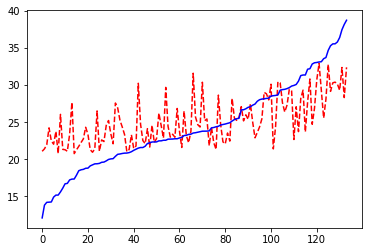

In [36]:
%matplotlib inline
plt.figure()
plt.plot(y_all_testregr_sorted[predicted_name].values,'r--',y_all_testregr_sorted[LABEL].values,'b')

Populating the interactive namespace from numpy and matplotlib


C:\Users\root\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


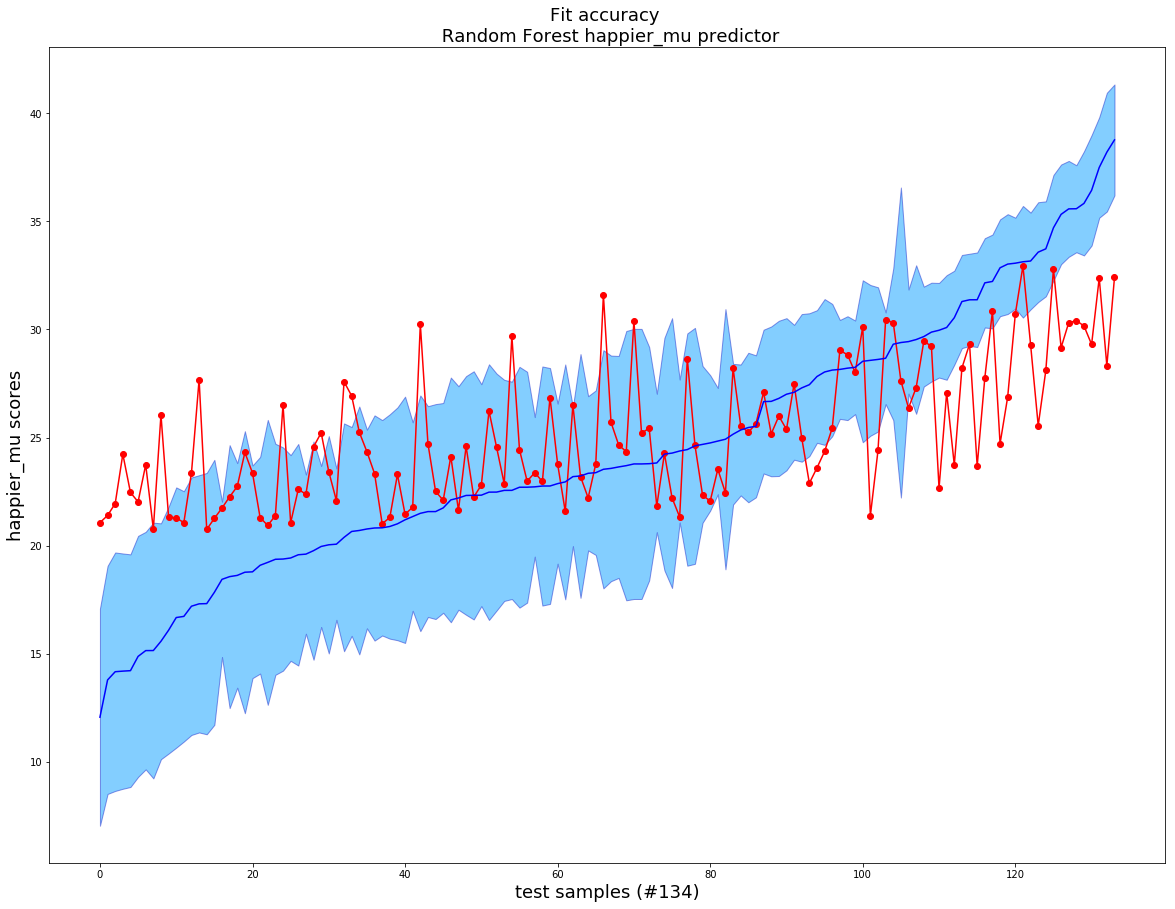

In [37]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_testregr_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_testregr_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_testregr_sorted[LABEL].values-y_all_testregr_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_testregr_sorted[LABEL].values+y_all_testregr_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_testregr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n Random Forest ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('test samples (#'+str(y_test[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

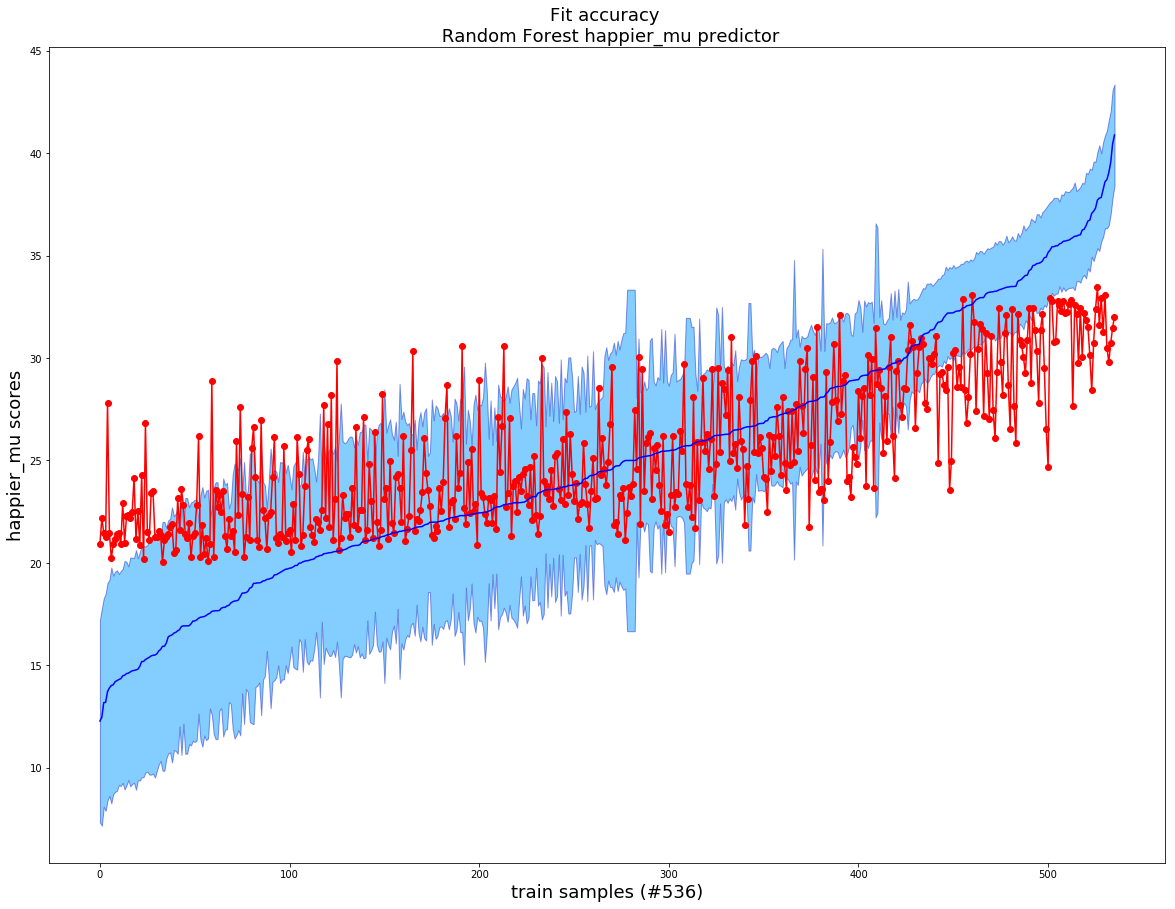

In [38]:
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_trainregr_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_trainregr_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_trainregr_sorted[LABEL].values-y_all_trainregr_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_trainregr_sorted[LABEL].values+y_all_trainregr_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_trainregr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n Random Forest ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('train samples (#'+str(y_train[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

Populating the interactive namespace from numpy and matplotlib


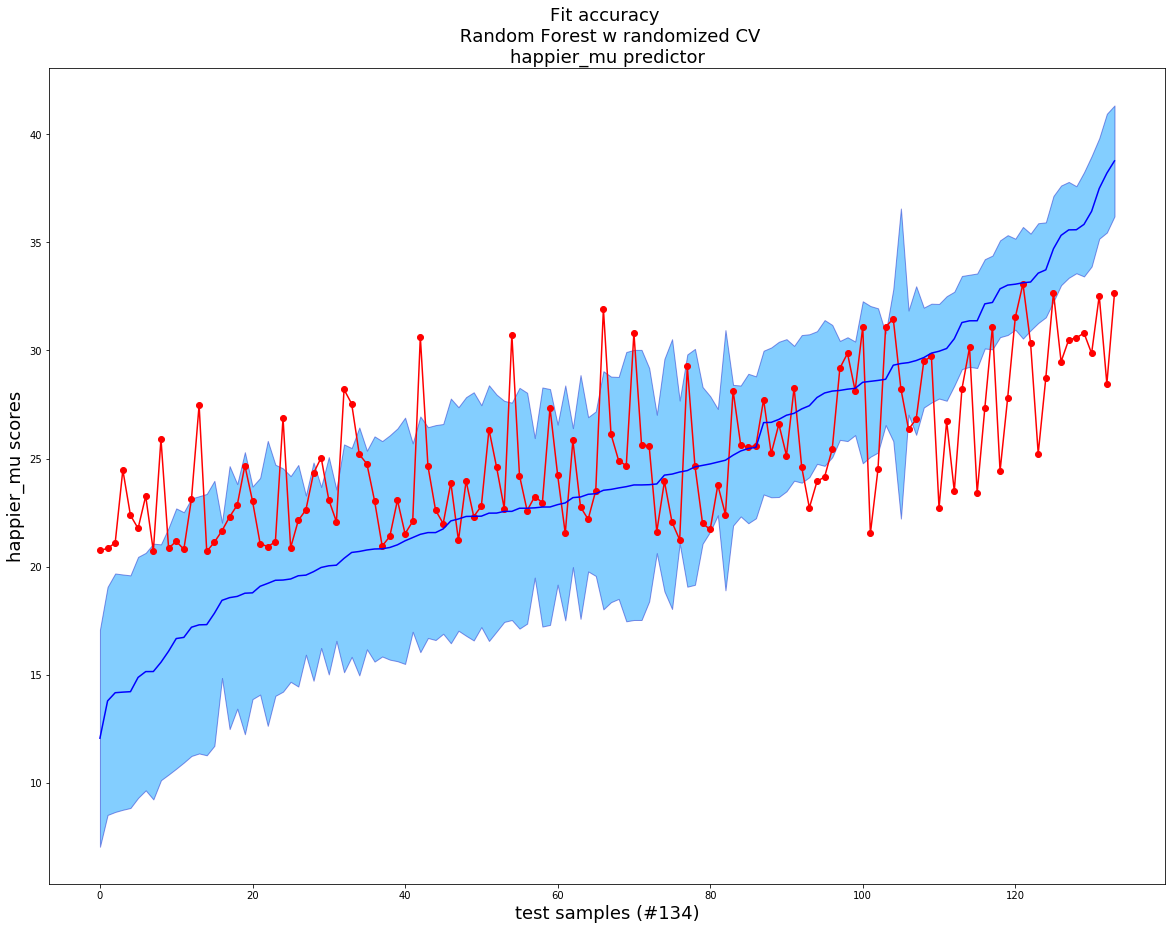

In [39]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_testregr_randcv_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_testregr_randcv_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_testregr_randcv_sorted[LABEL].values-y_all_testregr_randcv_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_testregr_randcv_sorted[LABEL].values+y_all_testregr_randcv_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_testregr_randcv_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n Random Forest w randomized CV\n' + LABEL + ' predictor',fontsize=18)
plt.xlabel('test samples (#'+str(y_test[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

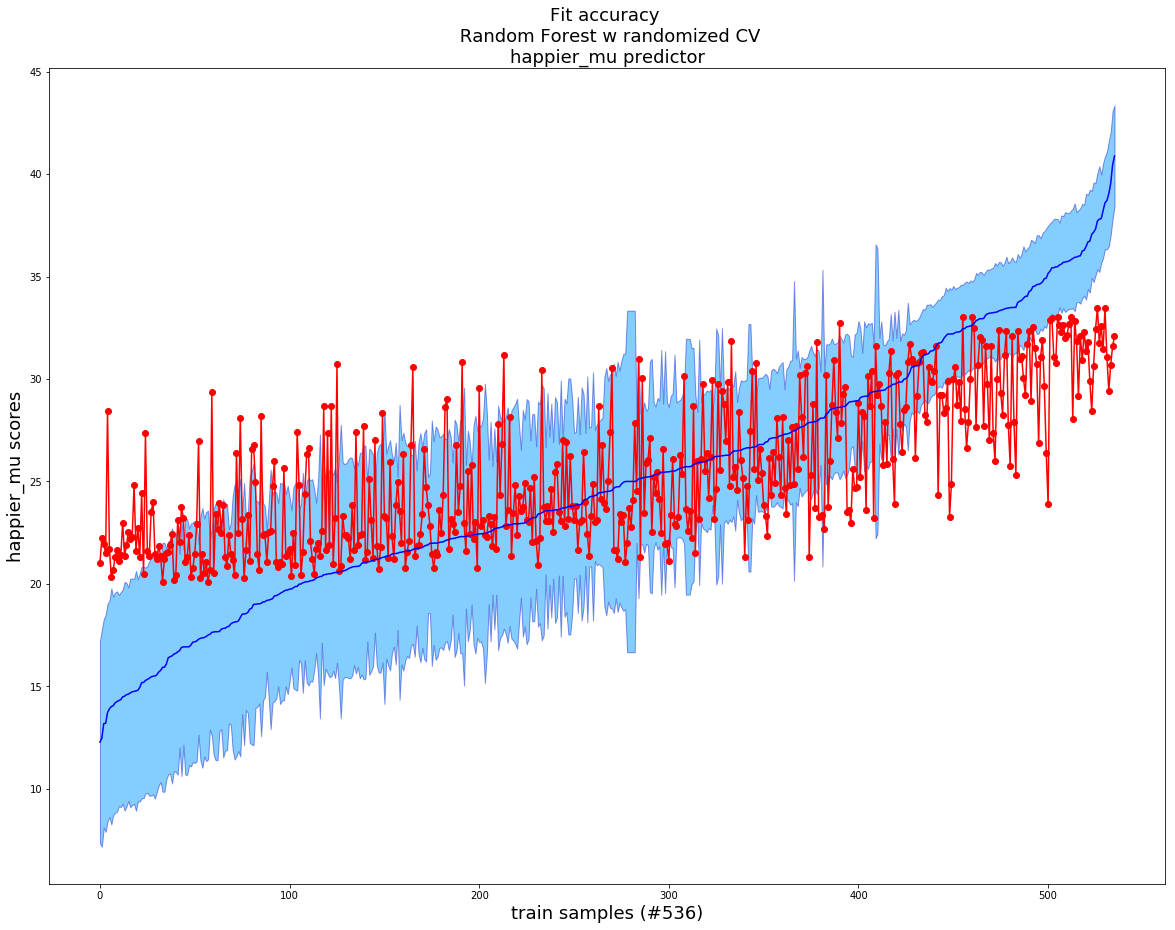

In [40]:
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_trainregr_randcv_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_trainregr_randcv_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_trainregr_randcv_sorted[LABEL].values-y_all_trainregr_randcv_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_trainregr_randcv_sorted[LABEL].values+y_all_trainregr_randcv_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_trainregr_randcv_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n Random Forest w randomized CV\n' + LABEL + ' predictor',fontsize=18)
plt.xlabel('train samples (#'+str(y_train[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

In [41]:
y_hat_lr = pd.DataFrame(ytest_pred_lr, columns=[predicted_name], index=y_test[LABEL].index) 

y_all_testlr = pd.concat([y_hat_lr, y_test[LABEL], y_test[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_testlr_sorted = y_all_testlr.sort_values(EMOSCORES[emotionid],ascending=[True])

ytrain_hat_lr = pd.DataFrame(ytrain_pred_lr, columns=[predicted_name], index=y_train[LABEL].index) 

y_all_trainlr = pd.concat([ytrain_hat_lr, y_train[LABEL], y_train[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_trainlr_sorted = y_all_trainlr.sort_values(EMOSCORES[emotionid],ascending=[True])

Populating the interactive namespace from numpy and matplotlib


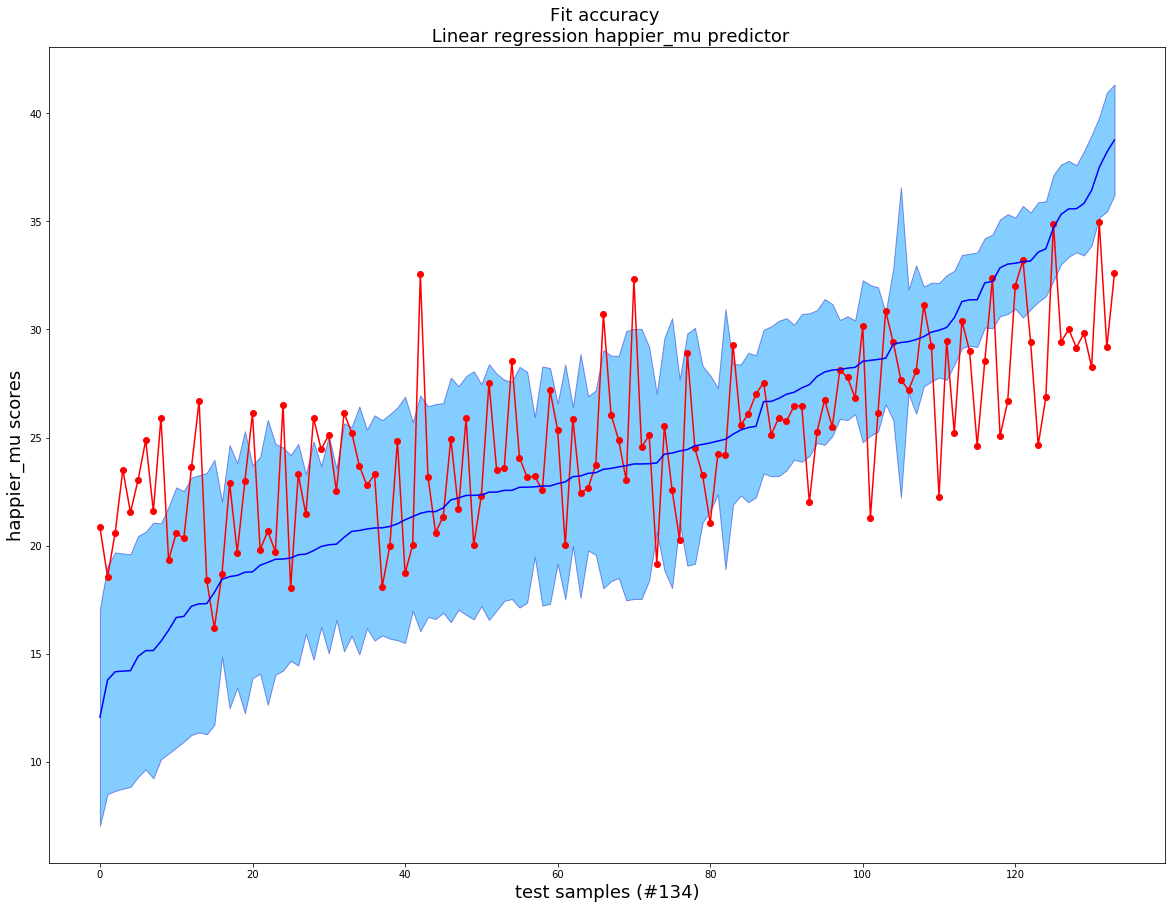

In [42]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_testlr_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_testlr_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_testlr_sorted[LABEL].values-y_all_testlr_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_testlr_sorted[LABEL].values+y_all_testlr_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_testregr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n Linear regression ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('test samples (#'+str(y_test[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

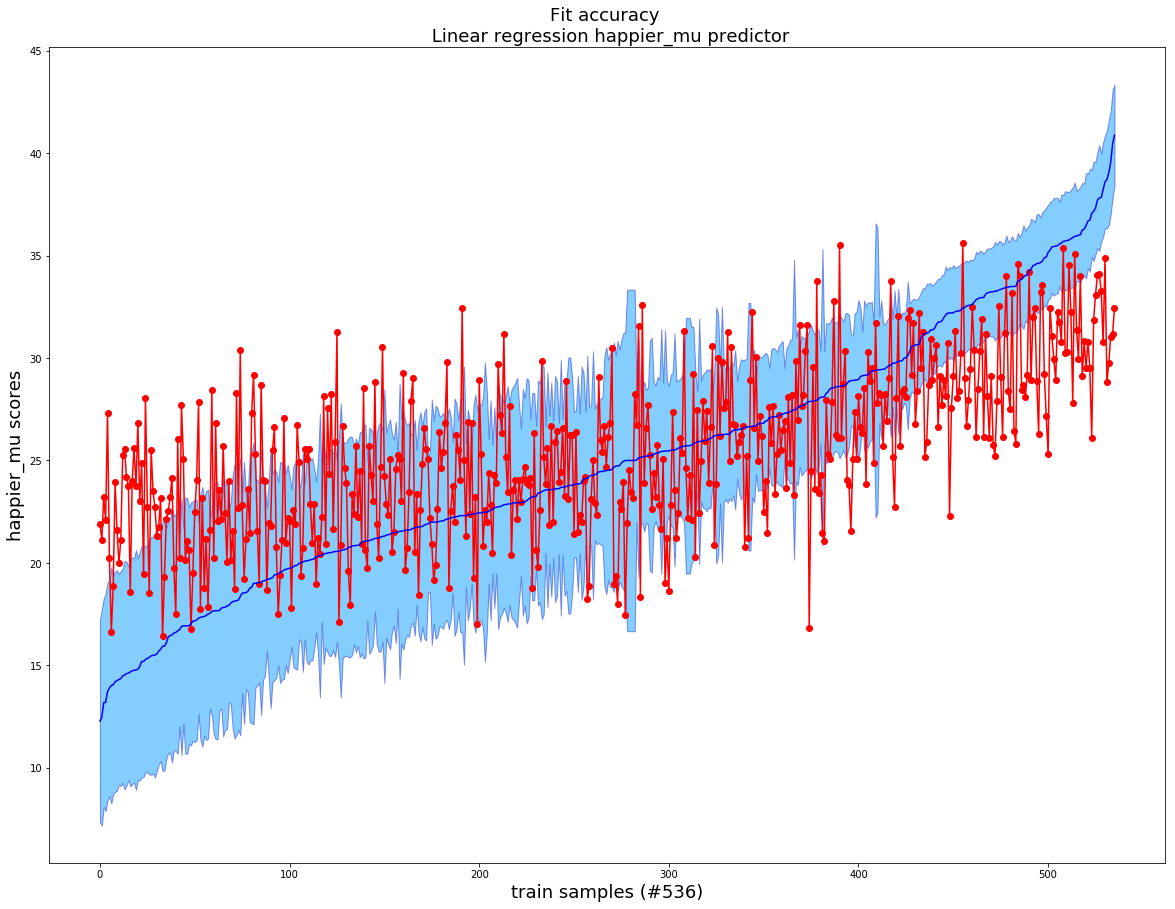

In [43]:
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_trainlr_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_trainlr_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_trainlr_sorted[LABEL].values-y_all_trainlr_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_trainlr_sorted[LABEL].values+y_all_trainlr_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_trainlr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n Linear regression ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('train samples (#'+str(y_train[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

In [44]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import numpy as np
import matplotlib.pyplot as plt


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.5,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.5, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

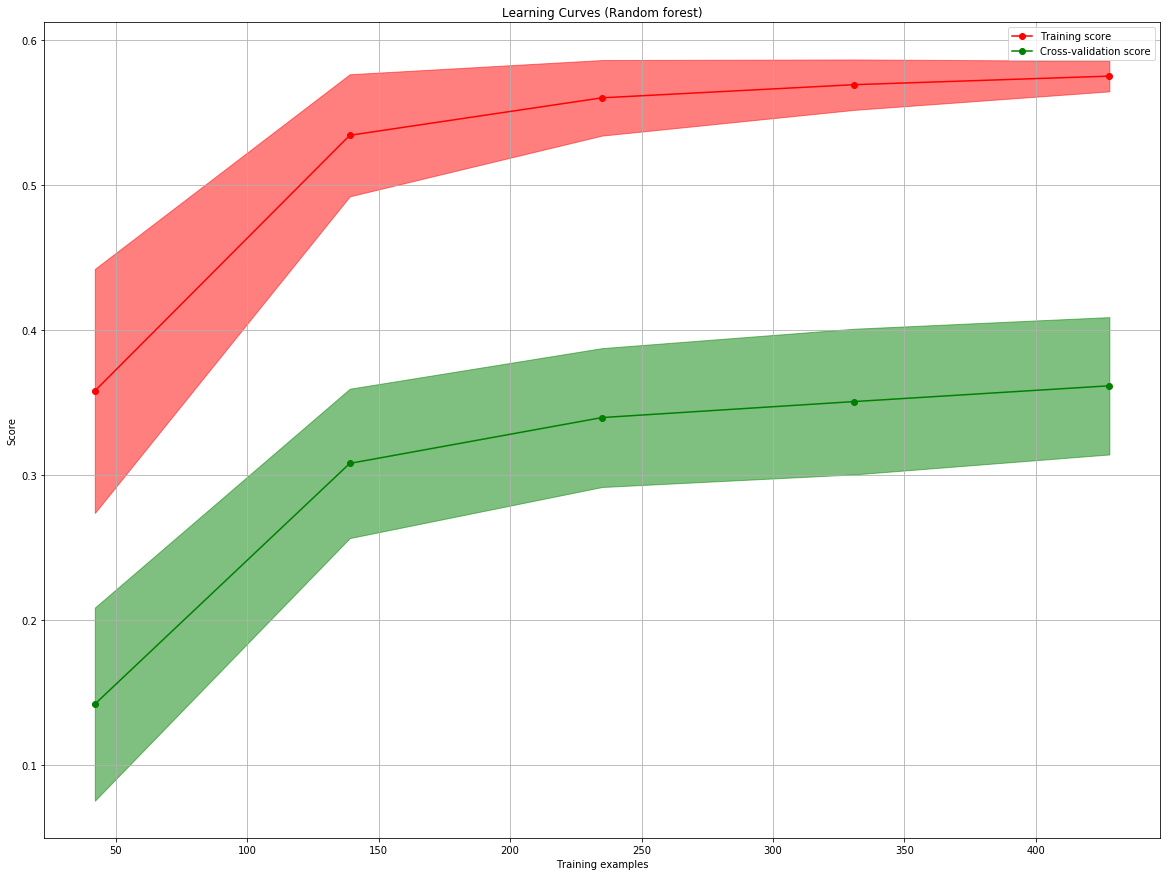

In [45]:
title = "Learning Curves (Random forest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

plot_learning_curve(grid_search.best_estimator_, title, X_train, y_train[EMOSCORES[emotionid]],  cv=cv, n_jobs=-1)

plt.show()

In [54]:
bestEstimator_testmse = mean_squared_error( y_test[EMOSCORES[emotionid]],ytest_pred,sample_weight=y_test[EMOWTS[emotionid]])
bestEstimator_testr2 = r2_score( y_test[EMOSCORES[emotionid]],ytest_pred,sample_weight=y_test[EMOWTS[emotionid]])

bestEstimator_trainmse = mean_squared_error( y_train[EMOSCORES[emotionid]],ytrain_pred,sample_weight=y_train[EMOWTS[emotionid]])
bestEstimator_trainr2 = r2_score( y_train[EMOSCORES[emotionid]],ytrain_pred,sample_weight=y_train[EMOWTS[emotionid]])

In [55]:
save_info = pd.DataFrame()
regr_info = pd.Series(str(grid_search.best_estimator_.get_params()))

In [56]:
save_info['trained'] = regr_info
save_info['regressor name'] = "RandomForestRegressor"
save_info['test wtd mse'] = bestEstimator_testmse
save_info['test wtd r2'] = bestEstimator_testr2
save_info['train wtd mse'] = bestEstimator_trainmse
save_info['train wtd r2'] = bestEstimator_trainr2
save_info['emotion'] = "happy"

In [57]:
with open('C:\\Users\\rutad\\Documents\\bitbucket\\pythonTF\\regressorExperiments.csv', 'a') as f:
    save_info.to_csv(f, header=False, index=False)

In [22]:
lr.coef_

array([-0.41480508,  0.38218341,  0.20352884, -0.4910056 , -0.13976998,
        0.20863598, -0.1450655 ,  0.62194128,  1.08971433, -2.61203257,
       -2.08402591,  4.62017766,  0.74334536, -0.82485776, -2.53116621,
       -1.9576796 , -0.30923316])